In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy
from util import load_sample,load_acertos, provas, params_inep, item_info_inep

%load_ext autoreload
%autoreload 2

sns.set_context('paper',font_scale=1.2,rc={"figure.figsize": (10,6)})
sns.set_style('darkgrid')

# Calcular as notas pela TRI
No notebook PrepareData tranformamos os microdados e as padrões de resposta dos candidatos num formato conveniente de 0 e 1 para os acertos. Vamos carregar os padrões com a função `load_acertos`. As últimas três colunas são o número de acertos, o número do caderno que o candidato usou e a nota que o INEP deu ao candidato. 

In [2]:
ano = 2023
area = 'MT'
padr = load_acertos(ano,area,5)
display(padr)

,126039,85504,28932,125935,126028,13725,141513,27119,125902,111754,...,27330,16795,141566,125884,84857,125888,125933,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210059637268,1,0,0,1,1,1,1,1,0,0,...,0,1,0,1,0,0,0,21,1211,686.8
210061279388,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,1,8,1213,400.5
210058499288,1,0,0,1,1,0,1,1,0,0,...,0,1,1,0,1,0,1,22,1211,684.7
210060252872,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,6,1212,398.5
210060436118,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,14,1213,498.7


Se quiser usar somente o padrão de resposta, tire estas últimas três colunas com o seguinte idioma (truque). Leia assim: iloc escolhe todas as linhas, e todas as colunas até a "última -3". 

In [3]:
padr.iloc[:,:-3]

,126039,85504,28932,125935,126028,13725,141513,27119,125902,111754,...,141567,98278,81946,27330,16795,141566,125884,84857,125888,125933
candidato,,,,,,,,,,,,,,,,,,,,,
210059637268,1,0,0,1,1,1,1,1,0,0,...,1,0,1,0,1,0,1,0,0,0
210061279388,0,0,0,1,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
210058499288,1,0,0,1,1,0,1,1,0,0,...,1,0,1,0,1,1,0,1,0,1
210060252872,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
210060436118,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Note que são 43 colunas, indicando que há 2 itens descartados pelo inep. Vamos conferir

In [4]:
params = params_inep(ano,area,dropna=False)
params[params['a_inep'].isna()]

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
86360,NaN,NaN,NaN,1
14887,NaN,NaN,NaN,1


Agora vamos transformar os padrões de resposta em nota, usando a Teoria de Resposta ao Item. 

A TRI propoe um modelo probabilístico para a geração de padrões de respostas como estes mostrado acima. O chamado modelo de três parâmetros logístico para a probabilidade de acertar um determinado item é:

$$ P(x=1|\theta) = c+ \frac{1-c}{1+e^{a(b-\theta )}} $$

onde os parâmetros $a,b$ e $c$ dependem da cada item e $P(x=1|\theta)$ é a probabilidade de acertar o item, dado uma habilidade $\theta$. Veja alguns parâmetros dos itens, segundo as calibrações do INEP:

In [5]:
ano = 2023
area = 'MT'
params = params_inep(ano, area).sample(5) # só 5 dos 45 itens, para ilustrar
params

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
24523,2.68656,2.50464,0.12713,1
86783,3.58609,3.00088,0.19242,1
31650,3.33563,1.08025,0.20912,1
98278,1.71891,2.19574,0.08744,1
28932,2.39434,1.98395,0.11508,1


In [6]:
def PL3(theta,a=1,b=0,c=0):
    return c + (1-c)*1/(1+np.exp(a*(b-theta)))

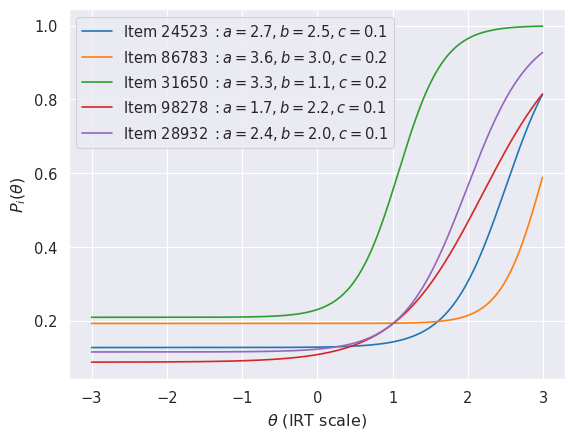

In [7]:
theta = np.arange(-3,3,0.01)

for item,param in params.iterrows():
    a,b,c = param['a_inep'],param['b_inep'],param['c_inep']
    ax = sns.lineplot(x=theta,y=PL3(theta,a,b,c), label=f"Item {item} $: a={a:.1f}, b={b:.1f}, c={c:.1f}$")
    ax.set_xlabel(r"$ \theta$ (IRT scale)")
    ax.set_ylabel(r"$P_i(\theta)$")

A TRI assume que um padrão de resposta é dado por uma sequência de "ensaios de Bernoulli" independentes (a probabilidade de acertar um item não deve depender, portanto, dos itens e respostas anteriores ou posteriores). Se isso for verdade, então a probabilidade de um determinado padrão de respostas $\{x_1, x_2 \ldots x_{45}\} = \{x_i\} = \vec{x}$, dado uma certa habilidade, é produto de 45 probabilidades $P_i(x_i=1)$ e $1-P_i(x_i=1)$:

$$ \text{prob}(\vec{x}|\theta)= \prod_{i=1}^{45} P_i(\theta)^{x_i} (1-P_i(\theta))^{1-x_{i}} $$ 

(Note que o $x_i = 0$ ou $1$ no expoente escolhe $P$ ou $1-P$). 

Vamos escrever funções que pegam os parâmetros TRI de uma ano e area, juntando com 1 ou mais padrões de resposta.

In [8]:
def padrparams(ano,area,n=None,nota_inep = False,orderby=None,acertos=None):
    'retorna padrão de resposta + parâmetros dos itens, com itens na linhas e candidatos nas colunas'
    params = params_inep(ano, area,dropna=True)
    if n:
        padr = load_acertos(ano,area,n,acertos=acertos)
    else:
        padr = load_acertos(ano,area,1,acertos=acertos)
    pp = params.join(padr.iloc[:,:-3].T,validate='1:1')
    if orderby:
        pp = pp.sort_values(orderby)
    if nota_inep:
        return pp,padr.iloc[:,-3:]
    else:
        return pp

def padr_prob(theta,padrparams,posterior = False):
    'Probabilidade de padrões de resposta, em função da habilidade theta'
    lh = np.ones(len(theta))
    for item,value in padrparams.iterrows():
        a,b,c = value['a_inep'],value['b_inep'],value['c_inep']
        acertou = value.iloc[-1] # asssumir que o padrão de respsosta é a última coluna
        if acertou:
            lh = lh*PL3(theta,a,b,c)
        else:
            lh = lh*(1-PL3(theta,a,b,c))
    if posterior:
        from scipy.stats import norm
        posterior = lh*norm.pdf(theta)
        return lh, posterior
    else:
        return lh

In [12]:
pp,nota_inep = padrparams(2023,'MT',nota_inep=True)
display(nota_inep)
pp[:4]

,acertos,caderno,nota_inep
candidato,,,
210058246158,18,1211,597.1


,a_inep,b_inep,c_inep,u,210058246158
CO_ITEM,,,,,
125929,1.58702,2.19080,0.24232,1,0
141582,1.46956,2.91942,0.24283,1,0
31650,3.33563,1.08025,0.20912,1,1
85504,2.21375,1.82985,0.15414,1,1


Qual a probabilidade desta padrão de resposta, dado os parâmetros dos itens e uma determinada habilidade $\theta = 1.4$ (1.4 desvios padrão acima da média = 0)? Vamos calcular usando a equação acima.

In [13]:
theta = np.array([1.4])
padr_prob(theta,pp)

array([1.53688252e-13])

Hmm, bem pequeno... Mas vamos ver para um array inteiro de theta, de -3 até 3 em passos de 0.01. 

<Axes: >

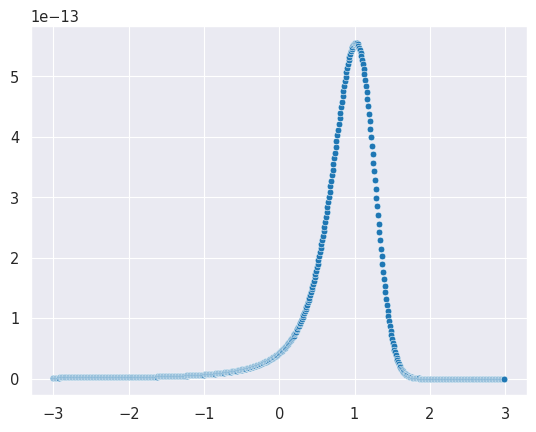

In [14]:
theta = np.arange(-3,3,0.01)
sns.scatterplot(x=theta,y=padr_prob(theta,pp))

Vemos que há um pico probabilidade em algum theta. Esta maneira de estimar a habilidade mais provável que gerou este padrão de resposta é chamado de "máxima verossimilhança". (A verossimilhança aqui é essencialmente o modelo para a probabilidade dos padrões de resposta, se considerar esta probabilidade como uma função do parâmetro theta e considerando os 45 parâmetros a, b e c como conhecidos e fixos).

Para fins didáticos, podemos mostrar como a probabilidade de acertar as questões evolui questão por questão. Na medida que mais informação entra (na forma de acertos e falhas de questões), o modelo "aprende" com cada vez mais precisão o que seria a habilidade theta associada a esta padrão de respostas.

In [15]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [16]:
def displaypadr(s):
    def check(s):
        if s: return '✔'
        else: return '✖'
    s = s.apply(check)
    s = ''.join(list(s.values))
    if len(s) > 20:
        return s[:20] + "\n" + s[20:]
    return s

padrs = load_acertos(2023,'MT',2)
for index,padr in padrs.iterrows():
    print(index,displaypadr(padr))

210060455997 ✔✖✖✔✖✖✖✖✔✖✔✖✖✖✔✖✖✖✖✖
✔✖✔✖✖✖✖✖✖✔✖✔✖✖✖✖✔✖✖✖✔✖✖✔✔✔
210060653748 ✖✖✖✖✖✖✔✖✖✔✖✖✖✖✖✖✔✖✖✔
✖✔✖✖✖✔✖✖✖✖✖✖✖✖✖✖✖✔✖✖✖✖✖✔✔✔


In [17]:
# escolher um padrão de resposta
ano = 2023
area = 'CN'
pp,nota_inep = padrparams(ano,area,nota_inep=True,acertos=9)
print(nota_inep)

def viz_padr_prob(pp,until=None,posterior=False,returnfig=False):
    'Gráfico da verossimilhança em função de theta, dado parâmetros TRI e um padrão de resposta'
    
    fig = plt.figure()
    theta = np.arange(-4,4,0.01)
    if until:
        pp = pp[:until]
    padr = pp.iloc[:,-1]
    s = displaypadr(padr)
    lh = padr_prob(theta,pp,posterior=posterior)
    ax = sns.scatterplot(x=theta,y=lh)
    nota_ml = (-4+lh.argmax()*0.01)
    lhmax = lh[lh.argmax()]
    #print(lhmax,nota_ml)
    ax.axvline(x=nota_ml,ymin=0,ymax=1,ls='--',lw=2,c='orange')
    ax.set_title(f"Após {until} respostas ("+s+")",loc='left')
    ax.set_xlabel(r"$\theta$ (unidade de desvio padrão)")
    ax.set_ylabel(r"$P(y_i|\theta$)")
    #ax.set_yticks([])
    if returnfig:
        return fig
    
iw = widgets.BoundedIntText(
    value=2,
    min=1,
    max=45,
    step=1,
    description='Número de repostas:',
    disabled=False
)

interact(viz_padr_prob,pp=fixed(pp),until=iw,posterior=fixed(False));
#fig = viz_padr_prob(pp,1)
#fig.savefig('images/test.png',dpi=300)

              acertos  caderno  nota_inep
candidato                                
210060951269        9     1223      392.9


interactive(children=(BoundedIntText(value=2, description='Número de repostas:', max=45, min=1), Checkbox(valu…

In [58]:
# para fazer um filminho...
acertos = 40
ano = 2023
area = 'MT'
pp,nota_inep = padrparams(ano,area,nota_inep=True,acertos=acertos)
for i in range(1,46):
    fig = viz_padr_prob(pp,i,returnfig=True)
    fig.savefig(f'images/tri/{acertos}/{area}-{ano}n{i}.png',dpi=300)
    plt.close(fig)

2016 / CN | 501.1 | 113.1 | 0.005


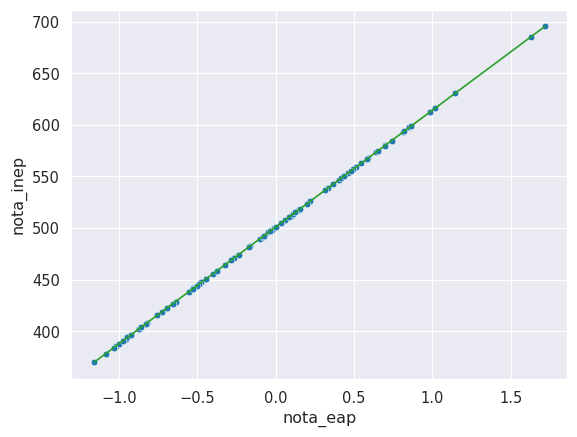

In [59]:
ano = 2016
area = 'CN'
theta = np.arange(-4,4,0.001)

d = {'acertos':[],'nota_inep':[],'nota_ml':[],'nota_eap':[]}
        
for i in range(100):
    pp,notas = padrparams(ano,area,1,nota_inep=True)
    nota, acertos = notas['nota_inep'].values[0], notas['acertos'].values[0]
    lh, posterior = padr_prob(theta,pp,posterior=True)
    nota_ml = (-4+lh.argmax()*0.001)
    nota_eap = np.average(theta, weights=posterior)
    d['acertos'].append(acertos)
    d['nota_inep'].append(nota)
    d['nota_ml'].append(nota_ml)
    d['nota_eap'].append(nota_eap)
df = pd.DataFrame(d)
res = scipy.stats.linregress(df['nota_eap'], df['nota_inep'])
sns.scatterplot(df,x='nota_eap',y='nota_inep')
sns.lineplot(x=df['nota_eap'],y=res.intercept + res.slope*df['nota_eap'],color='C2')
print(f"{ano} / {area} | {res.intercept:.1f} | {res.slope:.1f} | {res.stderr:.3f}")

✅ 2009, CN |	 501.1 |	 113.1 |	 0.004
✅ 2009, CH |	 501.5 |	 112.3 |	 0.003
✅ 2009, MT |	 500.0 |	 129.7 |	 0.004
✅ 2010, CN |	 501.1 |	 113.1 |	 0.005
✅ 2010, CH |	 501.5 |	 112.3 |	 0.003
✅ 2010, MT |	 500.0 |	 129.7 |	 0.003
✅ 2011, CN |	 501.1 |	 113.1 |	 0.004
❌ 2011, CH |	 539.9 |	 122.0 |	 5.688
✅ 2011, MT |	 500.0 |	 129.6 |	 0.003
✅ 2012, CN |	 501.1 |	 113.1 |	 0.004
✅ 2012, CH |	 501.5 |	 112.3 |	 0.004
✅ 2012, MT |	 500.0 |	 129.7 |	 0.005
✅ 2013, CN |	 501.1 |	 113.1 |	 0.004
✅ 2013, CH |	 501.5 |	 112.3 |	 0.004
❌ 2013, MT |	 518.8 |	 121.3 |	 3.731
✅ 2014, CN |	 501.1 |	 113.1 |	 0.006
✅ 2014, CH |	 501.5 |	 112.3 |	 0.004
✅ 2014, MT |	 500.0 |	 129.7 |	 0.005
✅ 2015, CN |	 501.1 |	 113.1 |	 0.005
✅ 2015, CH |	 501.5 |	 112.3 |	 0.005
✅ 2015, MT |	 500.0 |	 129.7 |	 0.004
✅ 2016, CN |	 501.1 |	 113.1 |	 0.004
✅ 2016, CH |	 501.5 |	 112.3 |	 0.005
✅ 2016, MT |	 500.0 |	 129.7 |	 0.005
❌ 2017, CN |	 512.6 |	 127.0 |	 4.655
❌ 2017, CH |	 510.8 |	 119.2 |	 3.941
❌ 2017, MT |

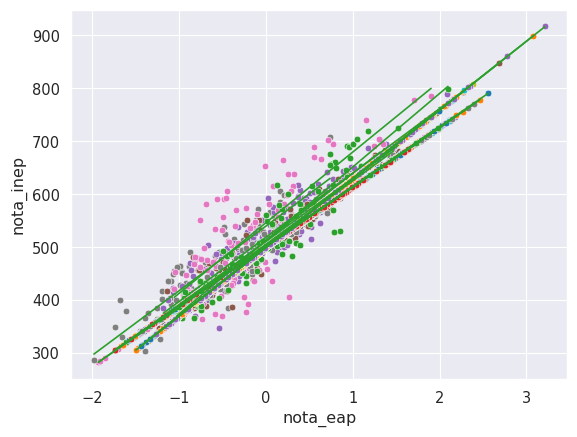

In [61]:
theta = np.arange(-4,4,0.001)

N = 100
results = pd.DataFrame(columns=['ano','area','slope','intercept','stderr','warning'])
for ano in range(2009,2024):
    for area in ['CN','CH','MT']:
        d = {'acertos':[],'nota_inep':[],'nota_ml':[],'nota_eap':[]}
        
        for i in range(N):
            pp,notas = padrparams(ano,area,1,nota_inep=True)
            nota, acertos = notas['nota_inep'].values[0], notas['acertos'].values[0]
            lh, posterior = padr_prob(theta,pp,posterior=True)
            nota_ml = (-4+lh.argmax()*0.001)
            nota_eap = np.average(theta, weights=posterior)
            d['acertos'].append(acertos)
            d['nota_inep'].append(nota)
            d['nota_ml'].append(nota_ml)
            d['nota_eap'].append(nota_eap)
        notas = pd.DataFrame(d)
        
        res = scipy.stats.linregress(notas['nota_eap'], notas['nota_inep'])
        sns.scatterplot(notas,x='nota_eap',y='nota_inep')
        sns.lineplot(x=notas['nota_eap'],y=res.intercept + res.slope*notas['nota_eap'],color='C2')
        if res.stderr < 0.05:
            warning = '✅'
        else: 
            warning = '❌'
        results.loc[len(results)] = [ano,area,res.slope,res.intercept,res.stderr,warning]
        print(f"{warning} {ano}, {area} |\t {res.intercept:.1f} |\t {res.slope:.1f} |\t {res.stderr:.3f}")
results['ano'] = results['ano'].astype('int')    
results.to_csv(f'data/scorecal-python-{N}.csv',index=False)

In [62]:
results.sort_values('ano')

,ano,area,slope,intercept,stderr,warning
0,2009,CN,113.111495,501.140501,0.003549,✅
1,2009,CH,112.319100,501.477873,0.003456,✅
2,2009,MT,129.656454,500.013585,0.004247,✅
3,2010,CN,113.107668,501.145898,0.004649,✅
4,2010,CH,112.310577,501.490185,0.003420,✅
5,2010,MT,129.650579,500.018103,0.003392,✅
6,2011,CN,113.112762,501.141848,0.004058,✅
7,2011,CH,122.032145,539.888883,5.688104,❌
8,2011,MT,129.649292,500.010650,0.003412,✅
11,2012,MT,129.667391,500.013974,0.004698,✅


## Comparar com `mirt`
Vamos comparar o cálculo da nota com nosso método caseira com os cálculos dos professionais, ou seja, a biblioteca `mirt` do Chalmers

In [48]:
from util import scalecalparams,score_inep

In [145]:
pp, nota_inep = padrparams(2023,'MT',1,nota_inep=True)
alpha,beta = scalecalparams('MT')
display(nota_inep)

,acertos,caderno,nota_inep
candidato,,,
210058201323,11,1214,437.2


In [146]:
padr = pd.DataFrame(pp.iloc[:,-1]).T

In [147]:
thetas = np.arange(-4,4,.001)
ll, posterior = padr_prob(thetas,pp,posterior=True)


In [149]:
nota_eap = np.average(thetas, weights=posterior)
nota_se = np.sqrt(np.average(thetas**2,weights=posterior)-nota_eap**2)
display(nota_eap*alpha + beta,nota_se*alpha)
nota_eap, nota_se

np.float64(437.18231876422686)

np.float64(83.1999389989869)

(np.float64(-0.4846133873069523), np.float64(0.6417030441342131))

In [150]:
score_inep(padr,2023,'MT')

,nota,se
210058201323,-0.484688,0.641916


In [141]:
np.sqrt(np.average(thetas**2,weights=posterior)-nota_eap**2)

np.float64(0.27157241481682537)

<Axes: >

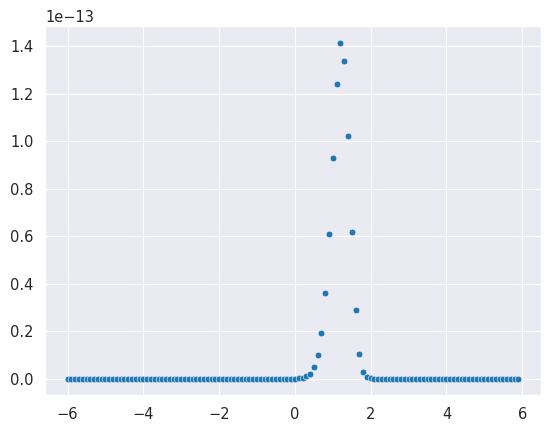

In [134]:
#sns.scatterplot(x=thetas,y=ll)
sns.scatterplot(x=thetas,y=thetas*posterior)